In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
import re
import os
import glob
import sys

# Directory where all the experiments are found. 
# Must end with "/" at the end
dir = "/Users/alexe/OM/atmp/res/"

#arch (used in function names for estimate of exec time)
zarch = "z17"

In [2]:
# Version with curve fitting models to a two variable function and --profile-ir approach
# data generated with script unit-new-meas/commands.sh

# graph: on the y axis it is seconds (because that is what make-report does by default.
# on the x axis for CPU: its the multiplication of each of the dims (for linear/non matmul). For matmul, its the matmul complexity
#    for NNPA, we do a regression and we take the proper ratio between the two metrics we use.

# For matrix multiply.
NNPA_N_CEIL  = 2.0
NNPA_N_CEIL2 = 32.0
NNPA_M_CEIL  = 64.0
NNPA_K_CEIL  = 64.0

# For elemntwise and others.
NNPA_E2_CEIL  = 2.0
NNPA_E2_CEIL2 = 32.0
NNPA_E1_CEIL  = 64.0

def ms_ceiling(n, m):
    return np.ceil(n/m) * m

def filter_complexity(df, dev_name, max_compute, min_mean, min_e1, min_e2):
    # cap of compute at val
    # cap of meas at 1.1us as the resolution of the timers is 1us.
    df_filter = df[(df["opCompute"] < max_compute) & (df["mean"] > min_mean) & (df["e1"]>=min_e1)  & (df["e2"]>=min_e2)] .copy()
    print(dev_name, ": original rows", df.shape[0], ", filtered rows", df_filter.shape[0])
    assert df_filter.shape[0]>0, "filtered too agressively, dev=" + dev_name + ", cap at=" + str(val) 
    return df_filter

def scan_csv(file_name):
    # Has no header, state so.
    df = pd.read_csv(file_name, header=None)
    # print(df.to_string())
    # Give names.
    df.columns =["titleTile", "e3", "e2", "e1", "titleOption", "option", "opName", "invokeNum", "measAverage", "mean", "percent"] 
    # Get rid of titles.
    df1 = df.drop(columns=["titleTile", "titleOption",  "opName",  "measAverage", "percent"])
    #print(df1.to_string())
    return df1

def prepare_cpu_data(df, op_name):
    # Get data for cpu, using "~" to indicate "all but the ones that...". . 
    df_cpu = df[~df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("CPU: Use MatMul 2D compute complexity.")
            # MatMul2D test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            df_cpu["opCompute"] = (df_cpu[N] * df_cpu[M] * df_cpu[K])
        else:
            print("CPU: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            # Namely the second matrix is square.
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Simply states broadcast B times N * M * K
            df_cpu["opCompute"] = df_cpu[B] * (df_cpu[N] * df_cpu[M] * df_cpu[K])
        code_cpu  = "(double B, double N, double M, double K) {\n"
        code_cpu += "  double complexity = B * (N * M * K);\n"
    else:
        df_cpu["opCompute"] = df_cpu["e3"] * df_cpu["e2"] * df_cpu["e1"]
        code_cpu  = "(double e3, double e2, double e1) {\n"
        code_cpu += "  double complexity = e3 * e2 * e1;\n"
    df_cpu["opTime"] = df_cpu["mean"]
    return (df_cpu, code_cpu)

def prepare_nnpa_data(df, op_name):
    # Get only the data for options with NNPA. 
    # Must add a copy to let Pandas know we want a whole new table, not a view.
    df_nnpa = df[df["option"].str.contains("-maccel=NNPA")].copy()
    if re.match(r'MatMul', op_name):
        if re.match(r'MatMul2D', op_name):
            print("NNPA: Use MatMul 2D compute complexity.")
            # MatMul test uses e1-3 in different ways: (N=e3 x M=e2) * (M=e2 x K=e1).
            (N, M, K) = ("e3", "e2", "e1")
            # not sure the formula below is correct.
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            df_nnpa["opCompute"]  = ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        else:
            print("NNPA: Use MatMul 3D compute complexity.")
            # MatMul test uses e1-3 in different ways: (B=e3 x N=e2 x M=e1) * (B=e3 x M=e1 x K=e1).
            (B, N, M, K) = ("e3", "e2", "e1", "e1")
            # Cedric's formula is ceil(N/2)*2 * ceil(M/64)*64 * ceil(K/64)*64. Works much better with ceil(N,32)*32.
            # Simply states broadcast B times Cedric's formula
            df_nnpa["opCompute"]  = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL)  * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
            df_nnpa["opCompute2"] = df_nnpa[B] * ms_ceiling(df_nnpa[N], NNPA_N_CEIL2) * ms_ceiling(df_nnpa[M], NNPA_M_CEIL) * ms_ceiling(df_nnpa[K], NNPA_K_CEIL)
        code_nnpa =  "(double B, double N, double M, double K) {\n"
        code_nnpa += "  double complexity  = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL, NNPA_M_CEIL, NNPA_K_CEIL)
        code_nnpa += "  double complexity2 = B * ms_ceiling(N, {:.1f}) * ms_ceiling(M, {:.1f}) * ms_ceiling(K, {:.1f});\n".format(NNPA_N_CEIL2, NNPA_M_CEIL, NNPA_K_CEIL)
    else:
        df_nnpa["opCompute"]  = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL)  * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        df_nnpa["opCompute2"] = df_nnpa["e3"] * ms_ceiling(df_nnpa["e2"], NNPA_E2_CEIL2) * ms_ceiling(df_nnpa["e1"], NNPA_E1_CEIL)
        code_nnpa  = "(double e3, double e2, double e1) {\n"
        code_nnpa += "  double complexity  = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL, NNPA_E1_CEIL)
        code_nnpa += "  double complexity2 = e3 * ms_ceiling(e2, {:.1f}) * ms_ceiling(e1, {:.1f});\n".format(NNPA_E2_CEIL2, NNPA_E1_CEIL)
    df_nnpa["opTime"] = df_nnpa["mean"]
    return (df_nnpa, code_nnpa)

def compute_regr(df, dev_name, op_name, color_name, print_graph=0):
    # Extract vectors for CPU regression, reshaping them as regression expect them to be: [lenCpu, 1].
    if dev_name == "NNPA":
        # Create an x array with one row per data point, and 2 columns, one for each complexity metric.
        x = np.vstack((df.opCompute.values, df.opCompute2.values)).T
    else:
        # create an x array with one row per data point and one column for the single complexity metric
        x = df.opCompute.values.reshape(-1, 1)
    y = df.opTime.values.reshape(-1, 1)
    #print(x, y)
    # Compute CPU Regression. See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    r2 = regr.score(x, y)
    # Compute a scatter friendly single dimension x for scatter analysis
    if dev_name == "NNPA":
        b = regr.coef_[0][0]
        c = regr.coef_[0][1]
        # 2D regression is f(x, y) = a + bx + cy
        # Now projecting (x, y) -> (z) where z = (bx + cy)/(b+c) 
        #   we get g(z) = a + (b + c)z  and by substituting z by its def above, we get
        #   g(z) = a + bx + cy 
        x_scatter = df.opCompute.values * b / (b+c) + df.opCompute2.values * c / (b+c)
    else:
        x_scatter = x

    print(dev_name, ": regression coef, ", regr.coef_, ", intercept", regr.intercept_, ", r2, ", r2)
    if print_graph >= 2:
        # Plot CPU regression
        plt.scatter(x_scatter, y,  color='black')
        plt.plot(x_scatter, regr.predict(x), color=color_name, linewidth=3)
        plt.title(op_name + " on " + dev_name + " with r2 " + str(r2))
        plt.show()
    if print_graph >= 3:
        df["opPredict"] = regr.predict(x)
        df["opErrorRatio"] = df["opPredict"] / df["opTime"]
        cutoff = 0.15
        df_predict_too_small = df[df["opErrorRatio"] < (1.0 - cutoff)].copy()
        predict_too_small_num = df_predict_too_small.shape[0]
        df_predict_too_big = df[df["opErrorRatio"] > (1.0 + cutoff)].copy()
        predict_too_big_num = df_predict_too_big.shape[0]
        print("Error for op", op_name, "and dev", dev_name);
        print("Measurement smaller than prediciton for", predict_too_big_num, "data points:\n")
        if predict_too_big_num > 0:
            print(df_predict_too_big.to_string(), "\n")
        print("Measurement larger than prediciton for", predict_too_small_num, "data points:\n")
        if predict_too_small_num > 0:
            print(df_predict_too_small.to_string(), "\n")
    return (regr, x, x_scatter, y, r2)

def print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph):
    plt.plot(x_cpu, regr_cpu.predict(x_cpu), color='blue', linewidth=1, label="CPU")
    plt.plot(x_scatter_nnpa, regr_nnpa.predict(x_nnpa), color='red', linewidth=1, label="NNPA")
    if print_graph>=2:
        plt.scatter(x_cpu, y_cpu, color='blue')
        plt.scatter(x_scatter_nnpa, y_nnpa, color='red')
    plt.legend()
    plt.title(op_name)
    plt.show()

def gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "static double " + zarch + "_estimatedTimeForCPU_" + c_op_name + "_" + code_cpu 
    code += "  // Regression for CPU with r2 = " + str(r2_cpu) + "\n"
    code += "  return " + str(regr_cpu.intercept_[0]) + " + " + str(regr_cpu.coef_[0][0]) + " * complexity;\n"
    code += "}\n"
    return code;

def gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa):
    c_op_name = op_name.replace("-", "_")
    code = "// Operation " + c_op_name + ": estimated times.\n"
    code +=  "static double " + zarch + "_estimatedTimeForNNPA_" + c_op_name + code_nnpa 
    code += "  // Regression for NNPA with r2 = " + str(r2_nnpa) + "\n"
    code += "  return " + str(regr_nnpa.intercept_[0]) + " + " + str(regr_nnpa.coef_[0][0]) + " * complexity +" + str(regr_nnpa.coef_[0][1]) + " * complexity2;\n"
    code += "}\n"
    return code;

def get_file_name_possibly_prefix(file_name):
    if os.path.exists(file_name):
        return file_name
    files = glob.glob(file_name + "*.csv")
    if len(files) == 0:
        print("could not find any files with prefix", file_name, "abort")
        sys.exit(1)
    if len(files) > 1:
        print("WARNING, got more than one file with prefix", file_name, "keep first one")
    print("used name as prefix to load this input file", files[0])
    return files[0]

#########################################################################################################
# Main entry point
# Scan file, filter, compute regression and generate code.
#########################################################################################################

def compute_reg(op_name, file_name, max_compute=1e6, min_mean=1.1e-6, min_e1=1, min_e2=32, print_graph=2):
    file_name = get_file_name_possibly_prefix(file_name)
    df = scan_csv(file_name)
    # Compute regression for CPU.
    (df_cpu_full, code_cpu) = prepare_cpu_data(df, op_name)
    has_cpu = df_cpu_full.shape[0] > 0
    code = ""
    if has_cpu:
        df_cpu = filter_complexity(df_cpu_full, "CPU", max_compute, min_mean, min_e1, min_e2)
        (regr_cpu, x_cpu, x_scatter_cpu, y_cpu, r2_cpu) = compute_regr(df_cpu, "CPU", op_name, "blue", print_graph)
        code += gen_cpu_code(op_name, regr_cpu, code_cpu, r2_cpu)
    # Compute regression for NNPA
    (df_nnpa_full, code_nnpa) = prepare_nnpa_data(df, op_name)
    has_nnpa = df_nnpa_full.shape[0] > 0
    if has_nnpa:
        df_nnpa = filter_complexity(df_nnpa_full, "NNPA", max_compute, min_mean, min_e1, min_e2)
        (regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, r2_nnpa) = compute_regr(df_nnpa, "NNPA", op_name, "red", print_graph)
        code += gen_nnpa_code(op_name, regr_nnpa, code_nnpa, r2_nnpa)
    if print_graph>=1 and has_cpu and has_nnpa:
        print_cross_over_graph(op_name, regr_cpu, x_cpu, y_cpu, regr_nnpa, x_nnpa, x_scatter_nnpa, y_nnpa, print_graph)
    if print_graph>=2:
        print(code);
    if has_cpu and has_nnpa:
        return {"cpu": regr_cpu, "nnpa": regr_nnpa, "code": code, "r2_cpu": r2_cpu, "r2_nnpa": r2_nnpa}
    if has_cpu:
        return {"cpu": regr_cpu, "code": code, "r2_cpu": r2_cpu}
    if has_nnpa:
        return {"nnpa": regr_nnpa, "code": code, "r2_nnpa": r2_nnpa}
    return {}


# Additional support.
def plot_regressions(db, list_of_op_dev, graph_title=""):
    x = [[0], [800000]]
    for tuple in list_of_op_dev:
        (op, dev) = tuple
        regr = db[op][dev]
        r2 = db[op]["r2_"+dev]
        label_name = op+"_"+dev+"_r2={:.2f}".format(r2)
        if dev=="nnpa":
            plt.plot(x, regr.predict(x), linewidth=1, linestyle='dashed', label=label_name)
        else:
            plt.plot(x, regr.predict(x), linewidth=1, label=label_name)            
    plt.legend()
    plt.title(graph_title)
    plt.show()

def eval_with_regr(db, op, sizes):
    if re.match(r'MatMul', op):
        (B, N, M, K) = sizes
        complexity_cpu = B * N * M * K
        complexity_nnpa = B * ms_ceiling(N, NNPA_N_CEIL) * ms_ceiling(M, NNPA_M_CEIL) * ms_ceiling(K, NNPA_K_CEIL)
    else:
        (e3, e2, e1) = sizes
        complexity_cpu = e3 * e2 * e1
        complexity_nnpa = B * ms_ceiling(e2, NNPA_E2_CEIL) * ms_ceiling(e1, NNPA_E1_CEIL)
    (x_cpu,  c_cpu)  = (db[op]["cpu"].coef_[0][0],  db[op]["cpu"].intercept_[0])
    (x_nnpa, c_nnpa) = (db[op]["nnpa"].coef_[0][0], db[op]["nnpa"].intercept_[0])
    time_cpu  = x_cpu  * complexity_cpu +  c_cpu
    time_nnpa = x_nnpa * complexity_nnpa +  c_nnpa
    print("Analysis for sizes", sizes)
    print("  CPU:  complexity " + str(complexity_cpu))
    print("  NNPA: complexity "+ str(complexity_nnpa))
    print("  CPU   time       " + str(time_cpu)  + " (" + str(x_cpu)  + ", " + str(c_cpu))
    print("  NNPA  time       " + str(time_nnpa) + " (" + str(x_nnpa) + ", " + str(c_nnpa))
    if (time_nnpa < time_cpu):
        print("  NNPA is faster")
    else:
        print("  CPU is faster")

In [3]:
# reset database of results
regdb = {}


used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_add_2025-08-11-14-59-07.csv
CPU : original rows 132 , filtered rows 39
CPU : regression coef,  [[1.11232015e-10]] , intercept [1.06872075e-07] , r2,  0.9535871953084981


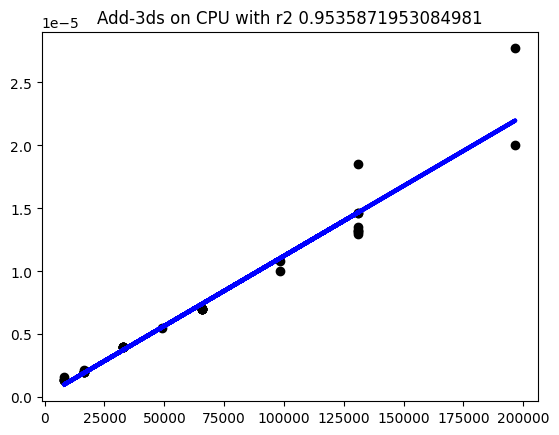

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.76091195e-11 1.76091195e-11]] , intercept [2.09624163e-06] , r2,  0.9766372565366345


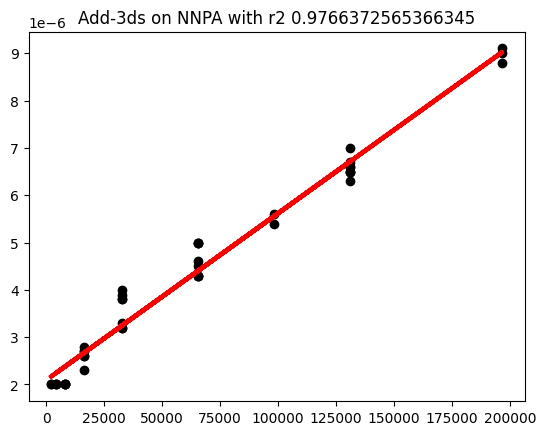

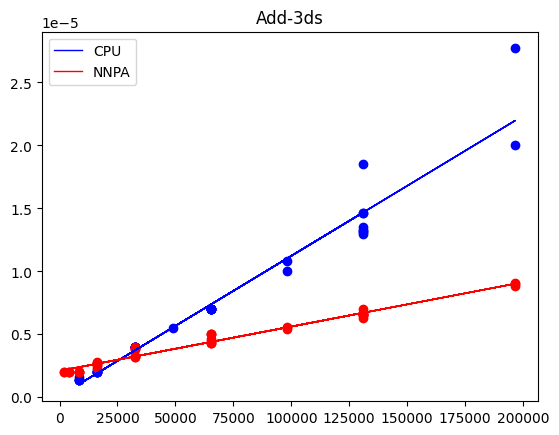

// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForCPU_Add_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9535871953084981
  return 1.068720751279869e-07 + 1.1123201461356356e-10 * complexity;
}
// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Add_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9766372565366345
  return 2.0962416302247326e-06 + 1.760911951128319e-11 * complexity +1.760911951128319e-11 * complexity2;
}



In [4]:
regdb["Add-3ds"] = compute_reg("Add-3ds", dir+"test_add_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_sub_2025-08-11-15-02-37.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.18437429e-10]] , intercept [-9.51928667e-07] , r2,  0.9572729795610849


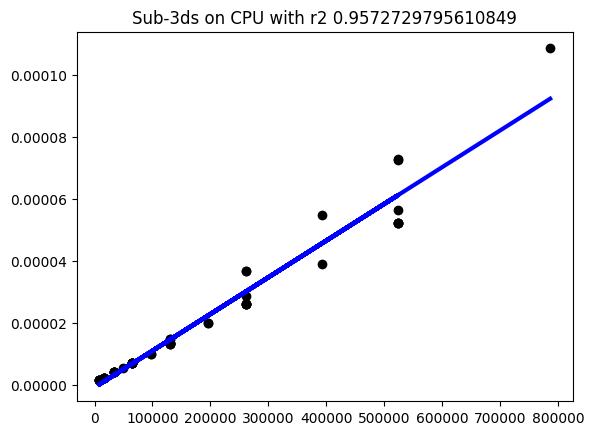

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.73809363e-11 1.73809363e-11]] , intercept [1.99691252e-06] , r2,  0.9948094324236897


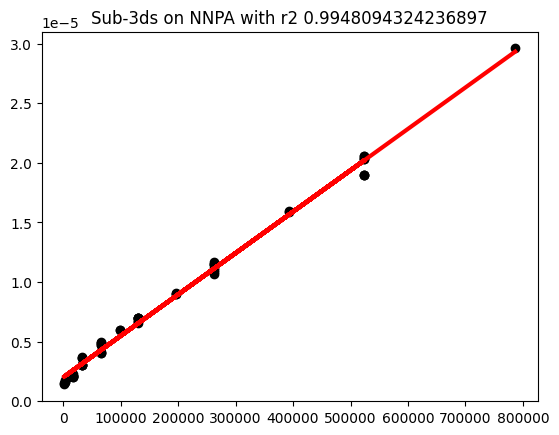

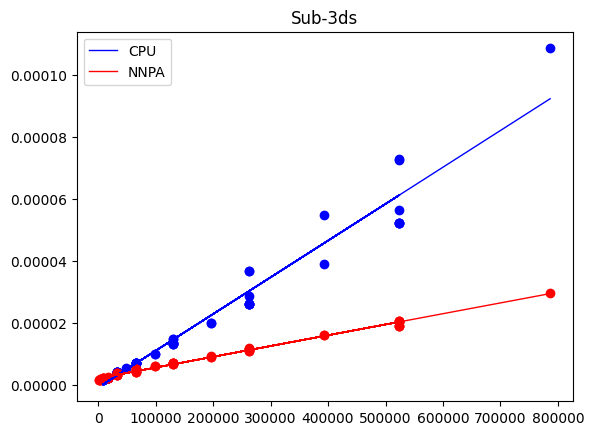

// Operation Sub_3ds: estimated times.
static double z17_estimatedTimeForCPU_Sub_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9572729795610849
  return -9.519286674245406e-07 + 1.1843742883867273e-10 * complexity;
}
// Operation Sub_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Sub_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9948094324236897
  return 1.996912523005288e-06 + 1.7380936332769716e-11 * complexity +1.7380936332769713e-11 * complexity2;
}



In [5]:
regdb["Sub-3ds"] = compute_reg("Sub-3ds", dir+"test_sub_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_div_2025-08-11-15-09-23.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[1.36132434e-09]] , intercept [6.09596037e-07] , r2,  0.9999962346317353


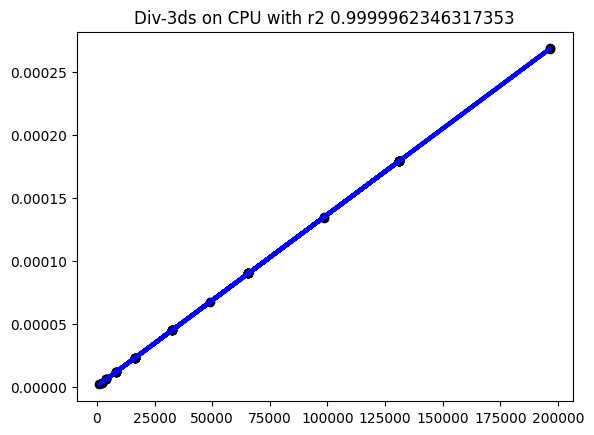

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[2.94083898e-11 2.94083898e-11]] , intercept [1.95511075e-06] , r2,  0.9920589568585376


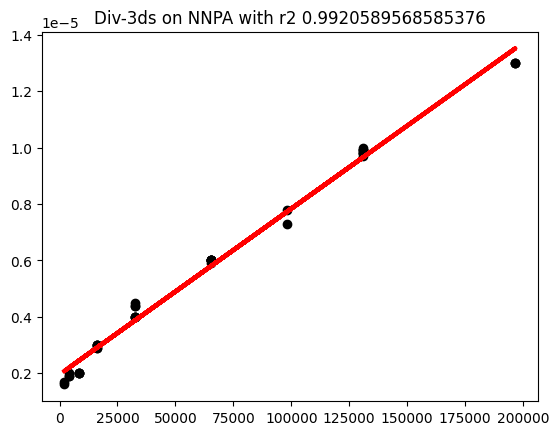

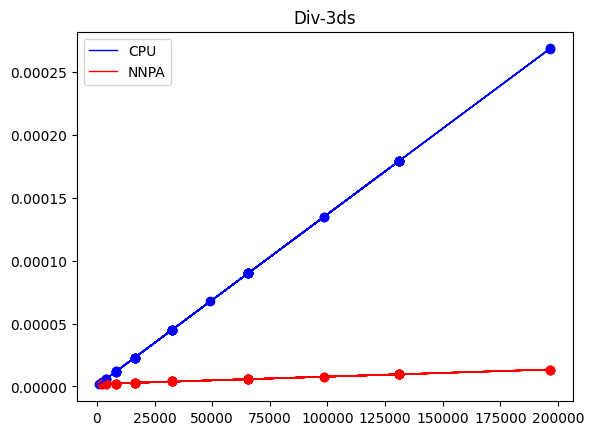

// Operation Div_3ds: estimated times.
static double z17_estimatedTimeForCPU_Div_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9999962346317353
  return 6.095960368522732e-07 + 1.3613243443680584e-09 * complexity;
}
// Operation Div_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Div_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9920589568585376
  return 1.955110750153735e-06 + 2.9408389838375506e-11 * complexity +2.9408389838375506e-11 * complexity2;
}



In [6]:
regdb["Div-3ds"] = compute_reg("Div-3ds", dir+"test_div_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_min_2025-08-11-15-16-55.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.05271466e-10]] , intercept [2.78125572e-07] , r2,  0.9707173756533475


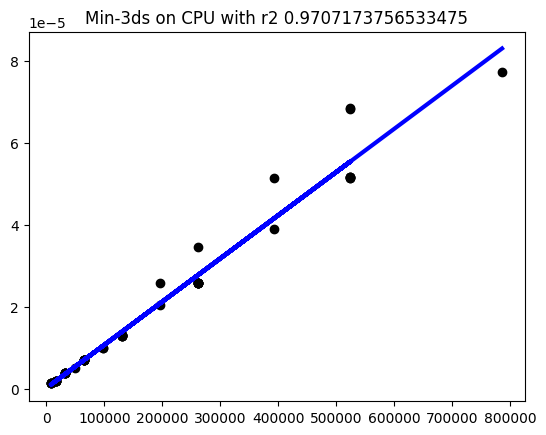

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.7291387e-11 1.7291387e-11]] , intercept [2.03075972e-06] , r2,  0.9940257300255695


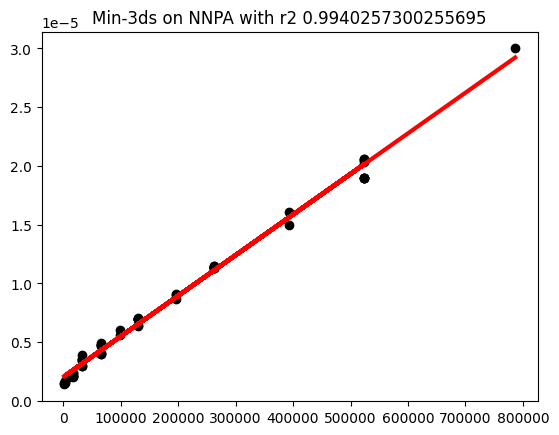

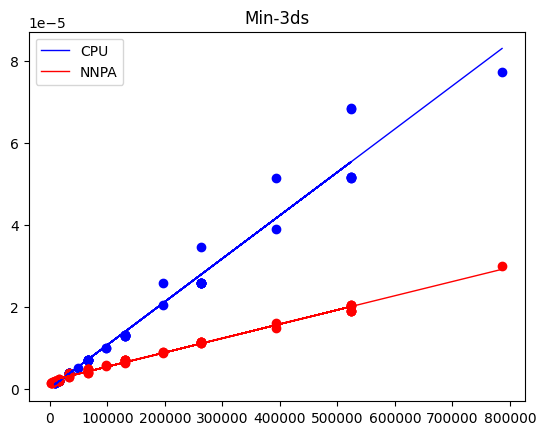

// Operation Min_3ds: estimated times.
static double z17_estimatedTimeForCPU_Min_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9707173756533475
  return 2.7812557201899635e-07 + 1.0527146606898085e-10 * complexity;
}
// Operation Min_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Min_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9940257300255695
  return 2.0307597171325136e-06 + 1.7291387002595746e-11 * complexity +1.7291387002595743e-11 * complexity2;
}



In [7]:
regdb["Min-3ds"] = compute_reg("Min-3ds", dir+"test_min_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_max_2025-08-11-15-13-27.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.17345996e-10]] , intercept [-1.20407651e-06] , r2,  0.9678291994916239


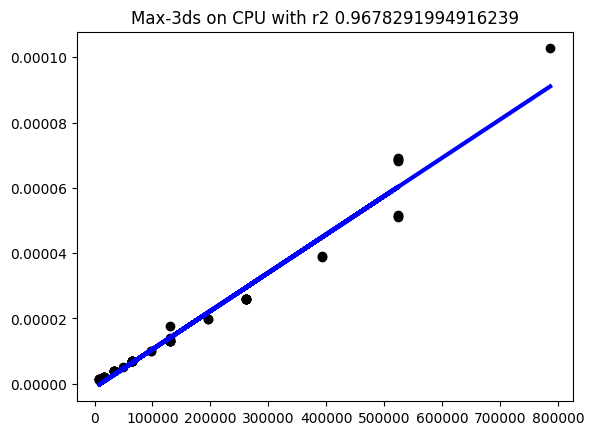

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.66090467e-11 1.66090467e-11]] , intercept [2.35924722e-06] , r2,  0.9932572043801817


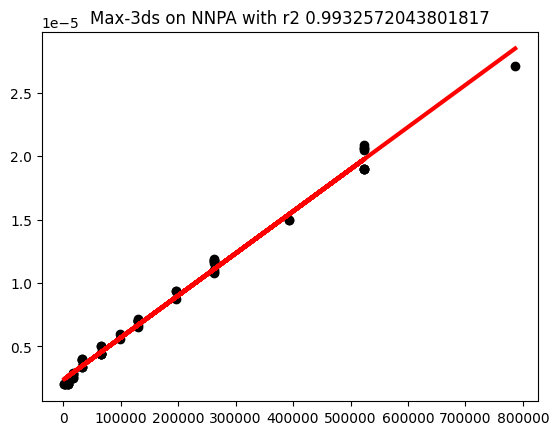

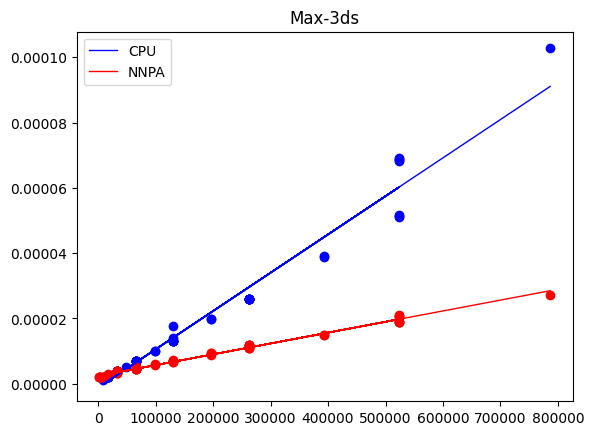

// Operation Max_3ds: estimated times.
static double z17_estimatedTimeForCPU_Max_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9678291994916239
  return -1.2040765084442103e-06 + 1.1734599595074527e-10 * complexity;
}
// Operation Max_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Max_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9932572043801817
  return 2.359247217183702e-06 + 1.660904673720443e-11 * complexity +1.660904673720443e-11 * complexity2;
}



In [8]:
regdb["Max-3ds"] = compute_reg("Max-3ds", dir+"test_max_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_mul_2025-08-11-15-06-06.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.24683126e-10]] , intercept [-1.6793061e-06] , r2,  0.9592436283162125


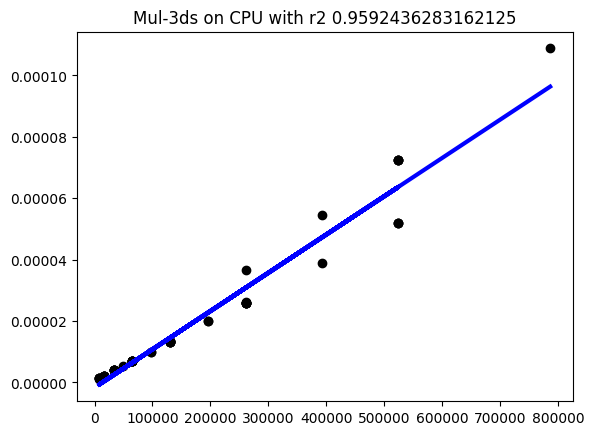

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.74620224e-11 1.74620224e-11]] , intercept [1.94337868e-06] , r2,  0.9955781495398514


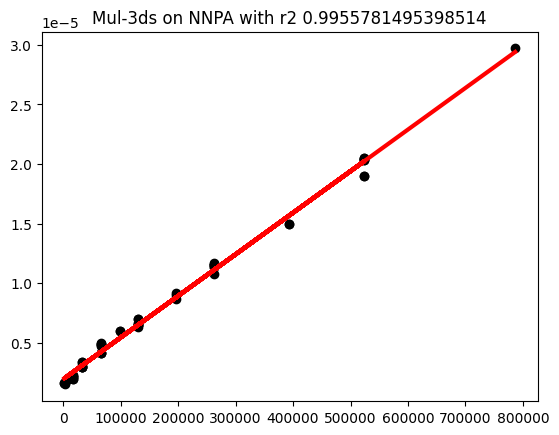

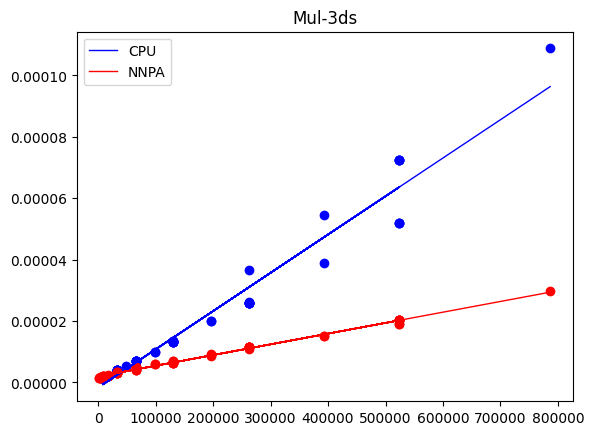

// Operation Mul_3ds: estimated times.
static double z17_estimatedTimeForCPU_Mul_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9592436283162125
  return -1.6793060988063483e-06 + 1.2468312599510607e-10 * complexity;
}
// Operation Mul_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Mul_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9955781495398514
  return 1.943378683529745e-06 + 1.746202243627608e-11 * complexity +1.7462022436276078e-11 * complexity2;
}



In [9]:
regdb["Mul-3ds"] = compute_reg("Mul-3ds", dir+"test_mul_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_pow-2_2025-08-11-16-27-42.csv
CPU : original rows 132 , filtered rows 57
CPU : regression coef,  [[1.12082119e-10]] , intercept [-2.58105329e-07] , r2,  0.9571343222117387


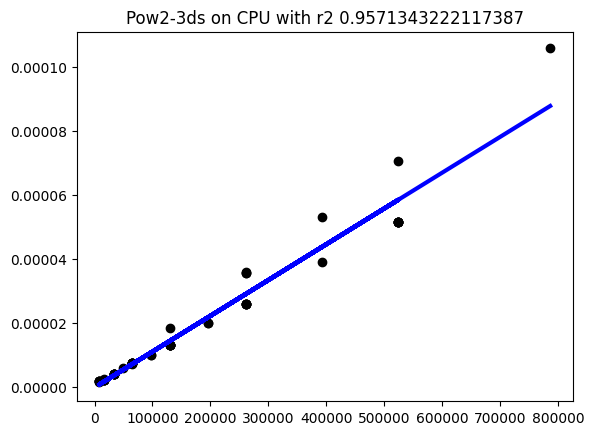

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.76038447e-11 1.76038447e-11]] , intercept [1.95778579e-06] , r2,  0.9964513575641324


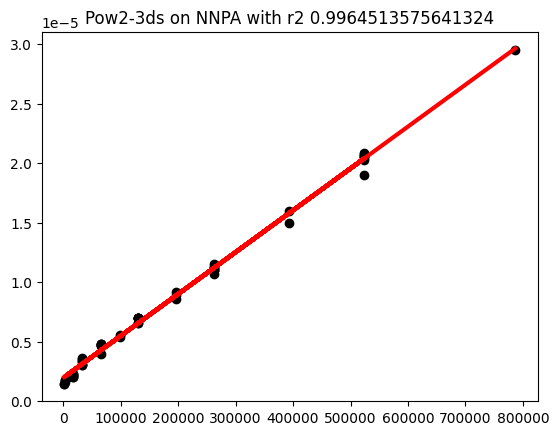

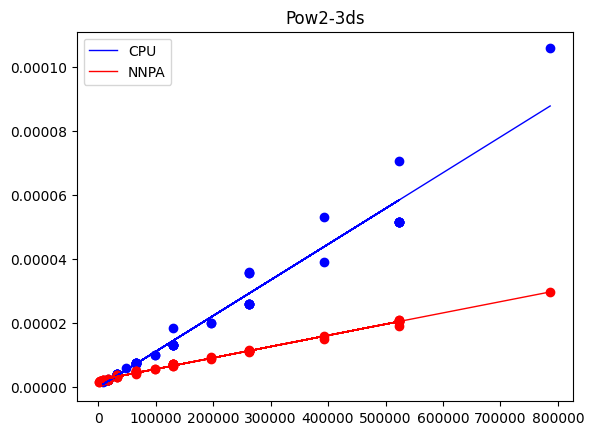

// Operation Pow2_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow2_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9571343222117387
  return -2.5810532856771956e-07 + 1.1208211871810246e-10 * complexity;
}
// Operation Pow2_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow2_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9964513575641324
  return 1.9577857864635168e-06 + 1.7603844726150348e-11 * complexity +1.760384472615034e-11 * complexity2;
}



In [10]:
# pow2 is the same as mul in our experiments
regdb["Pow2-3ds"] = compute_reg("Pow2-3ds", dir+"test_pow-2_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_pow-3_2025-08-11-16-31-01.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.22424965e-10]] , intercept [1.84854749e-06] , r2,  0.9995699502718259


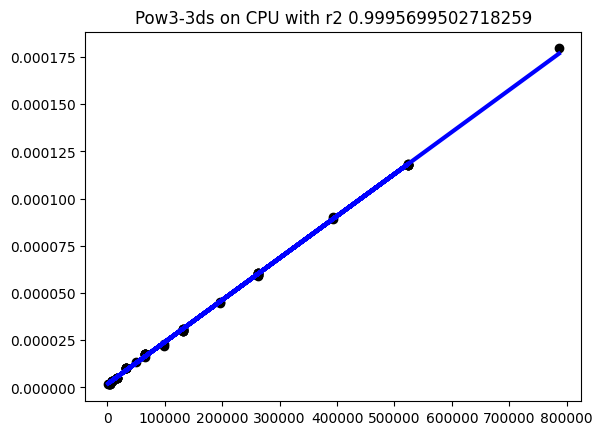

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.4158516e-11 3.4158516e-11]] , intercept [3.99207832e-06] , r2,  0.9969013634757655


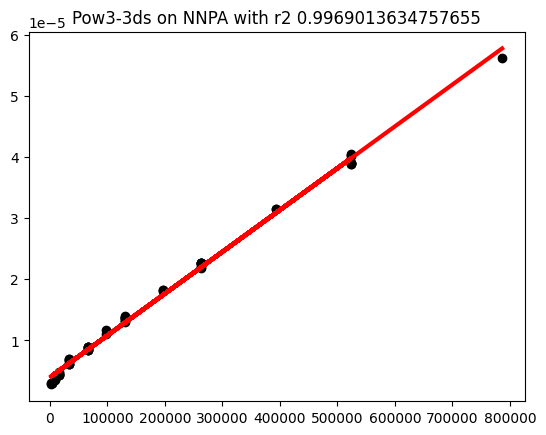

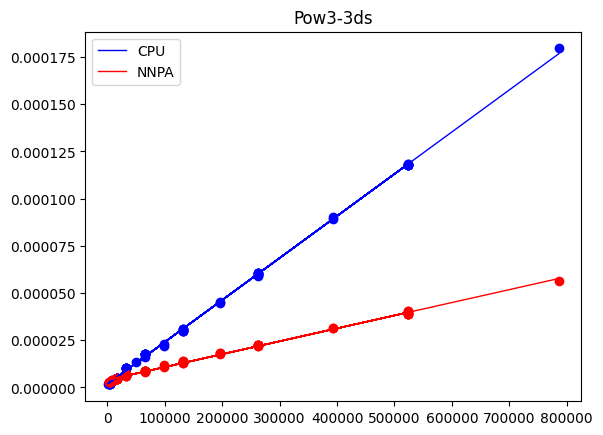

// Operation Pow3_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow3_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9995699502718259
  return 1.848547488485713e-06 + 2.2242496500529288e-10 * complexity;
}
// Operation Pow3_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow3_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9969013634757655
  return 3.9920783193044195e-06 + 3.415851595154875e-11 * complexity +3.4158515951548746e-11 * complexity2;
}



In [11]:
regdb["Pow3-3ds"] = compute_reg("Pow3-3ds", dir+"test_pow-3_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_pow-4_2025-08-11-16-35-35.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[1.92024532e-10]] , intercept [9.59929533e-07] , r2,  0.9965215587852863


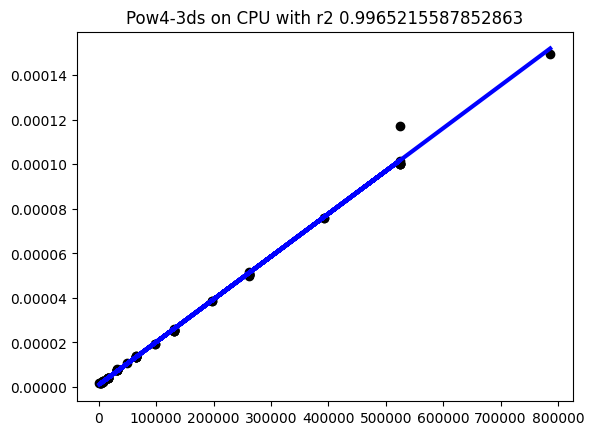

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.36562696e-11 3.36562696e-11]] , intercept [4.17188595e-06] , r2,  0.9931433804210715


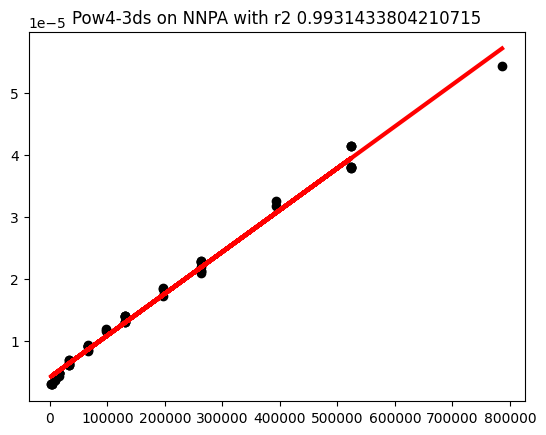

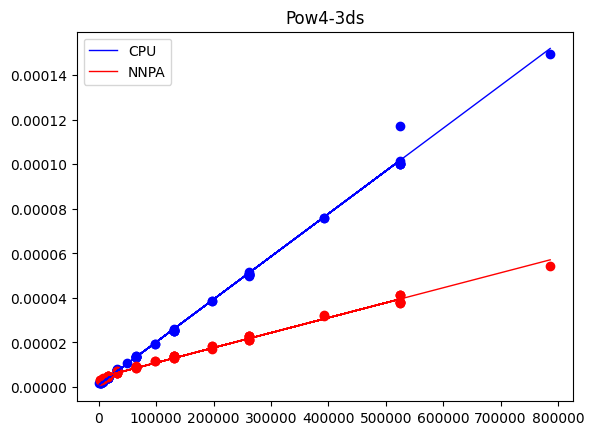

// Operation Pow4_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow4_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9965215587852863
  return 9.59929533167501e-07 + 1.9202453223717308e-10 * complexity;
}
// Operation Pow4_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow4_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9931433804210715
  return 4.171885951594051e-06 + 3.365626957469952e-11 * complexity +3.365626957469951e-11 * complexity2;
}



In [12]:
regdb["Pow4-3ds"] = compute_reg("Pow4-3ds", dir+"test_pow-4_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_pow-8_2025-08-11-16-39-51.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[2.72552298e-10]] , intercept [2.56820741e-06] , r2,  0.999341610105961


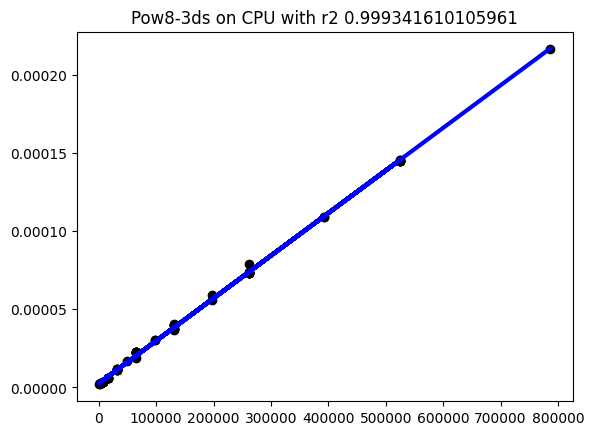

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[5.1377427e-11 5.1377427e-11]] , intercept [6.0589115e-06] , r2,  0.9944685997774384


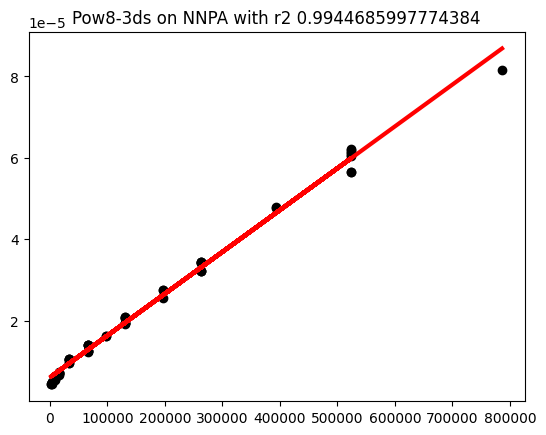

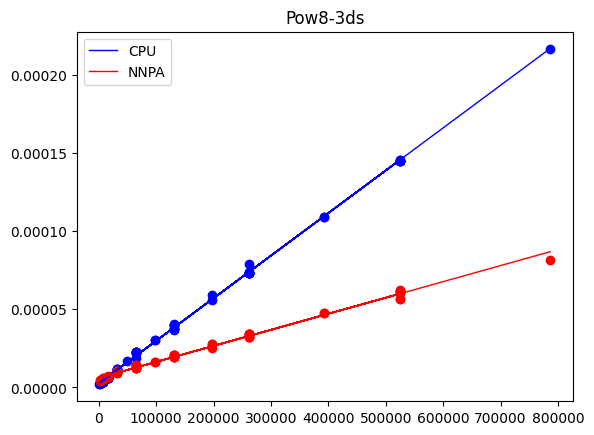

// Operation Pow8_3ds: estimated times.
static double z17_estimatedTimeForCPU_Pow8_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.999341610105961
  return 2.568207408534676e-06 + 2.7255229799216694e-10 * complexity;
}
// Operation Pow8_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Pow8_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9944685997774384
  return 6.058911502216365e-06 + 5.1377427013584014e-11 * complexity +5.137742701358401e-11 * complexity2;
}



In [13]:
regdb["Pow8-3ds"] = compute_reg("Pow8-3ds", dir+"test_pow-8_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_relu_2025-08-12-15-56-14.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[1.14173621e-10]] , intercept [-2.86169109e-07] , r2,  0.9579967502478688


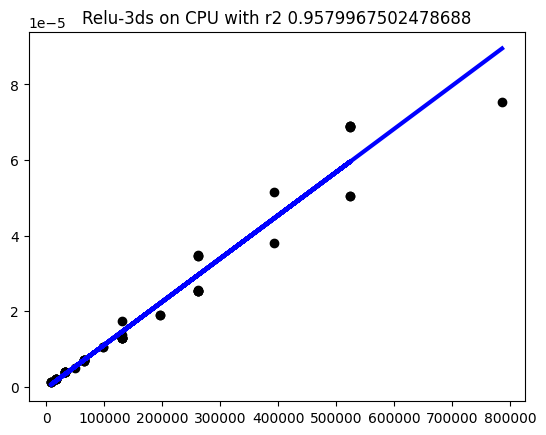

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.2966881e-11 2.2966881e-11]] , intercept [1.94808941e-06] , r2,  0.9998160434010518


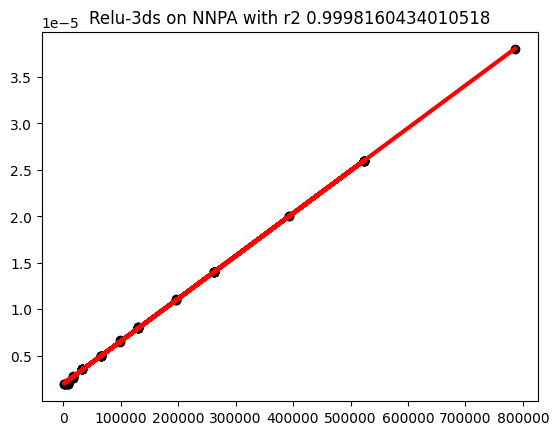

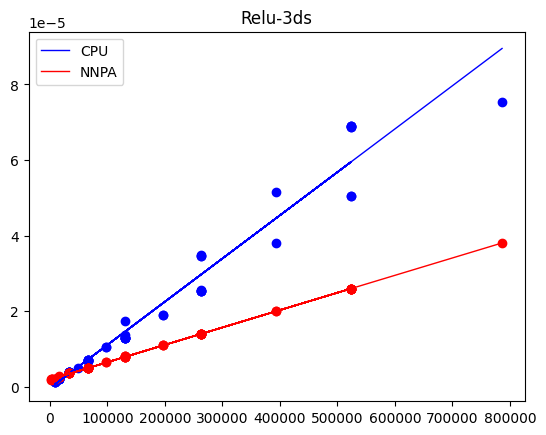

// Operation Relu_3ds: estimated times.
static double z17_estimatedTimeForCPU_Relu_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9579967502478688
  return -2.861691094358903e-07 + 1.1417362132461521e-10 * complexity;
}
// Operation Relu_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Relu_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9998160434010518
  return 1.9480894147067304e-06 + 2.2966881035979922e-11 * complexity +2.2966881035979922e-11 * complexity2;
}



In [14]:
regdb["Relu-3ds"] = compute_reg("Relu-3ds", dir+"test_relu_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_gelu_2025-08-11-15-21-15.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.46662988e-08]] , intercept [4.3601524e-05] , r2,  0.9984494437800732


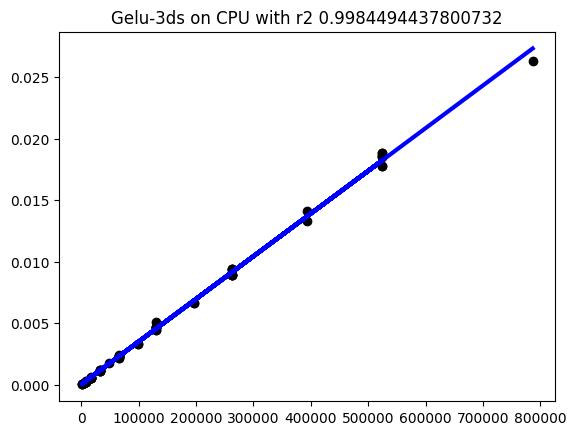

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.51306403e-11 3.51306403e-11]] , intercept [1.96449917e-06] , r2,  0.9997332856981352


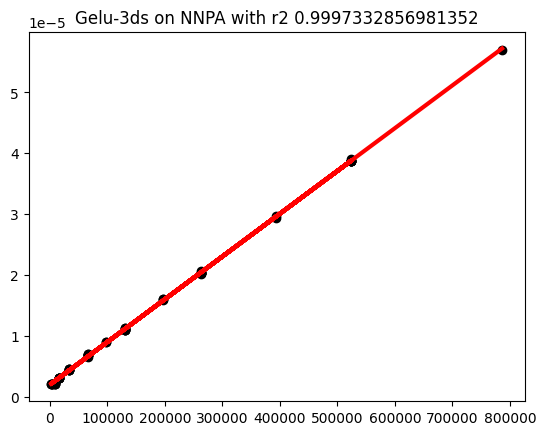

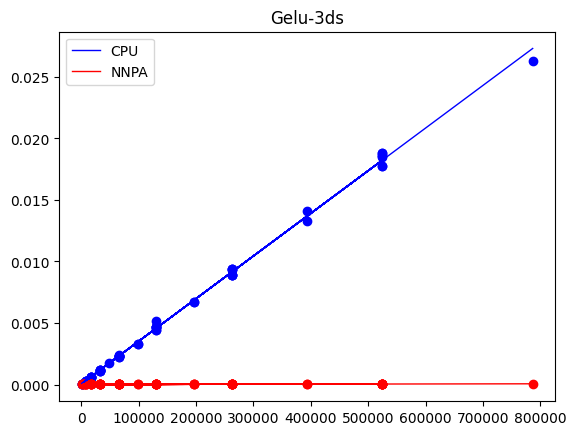

// Operation Gelu_3ds: estimated times.
static double z17_estimatedTimeForCPU_Gelu_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9984494437800732
  return 4.360152401461977e-05 + 3.4666298781543725e-08 * complexity;
}
// Operation Gelu_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Gelu_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9997332856981352
  return 1.9644991675221836e-06 + 3.5130640309429585e-11 * complexity +3.5130640309429585e-11 * complexity2;
}



In [15]:
regdb["Gelu-3ds"] = compute_reg("Gelu-3ds", dir+"test_gelu_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_sigmoid_2025-08-11-16-03-09.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[4.95419942e-09]] , intercept [-2.78373305e-07] , r2,  0.9997580597867987


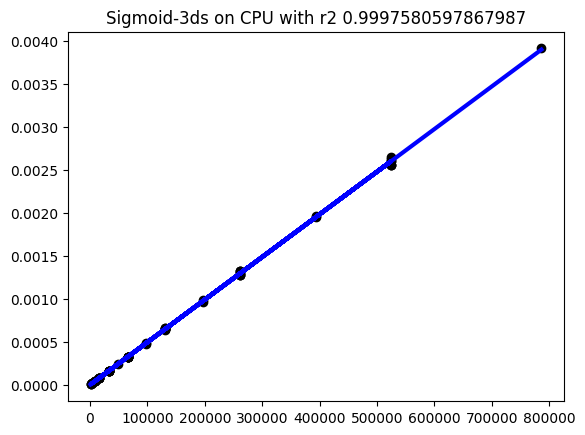

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.73501279e-11 3.73501279e-11]] , intercept [1.79102939e-06] , r2,  0.9997372303805214


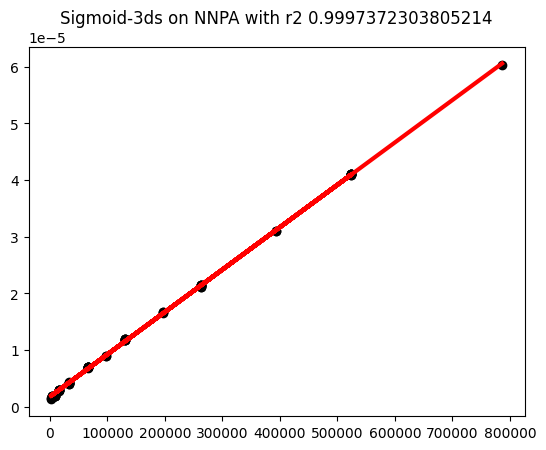

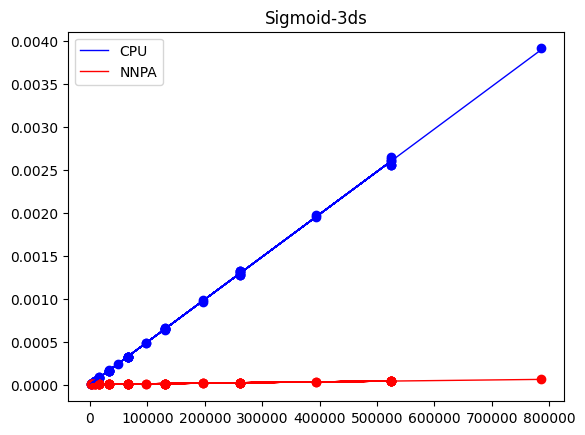

// Operation Sigmoid_3ds: estimated times.
static double z17_estimatedTimeForCPU_Sigmoid_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9997580597867987
  return -2.783733053103154e-07 + 4.954199421834201e-09 * complexity;
}
// Operation Sigmoid_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Sigmoid_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9997372303805214
  return 1.7910293860884082e-06 + 3.735012794093791e-11 * complexity +3.735012794093791e-11 * complexity2;
}



In [16]:
regdb["Sigmoid-3ds"] = compute_reg("Sigmoid-3ds", dir+"test_sigmoid_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_tanh_2025-08-11-15-43-21.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.095872e-08]] , intercept [-0.00018633] , r2,  0.9877462972947725


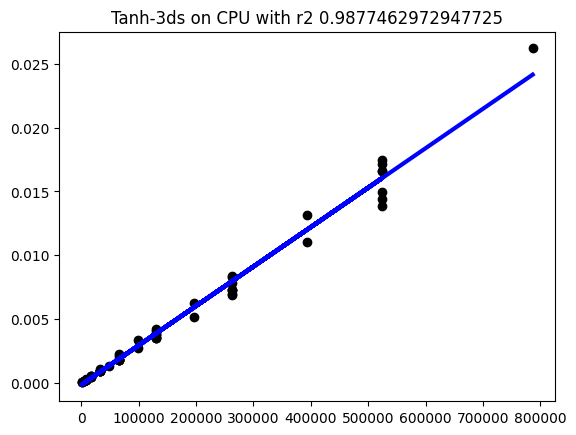

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.6890048e-11 1.6890048e-11]] , intercept [1.90993305e-06] , r2,  0.9987248322972831


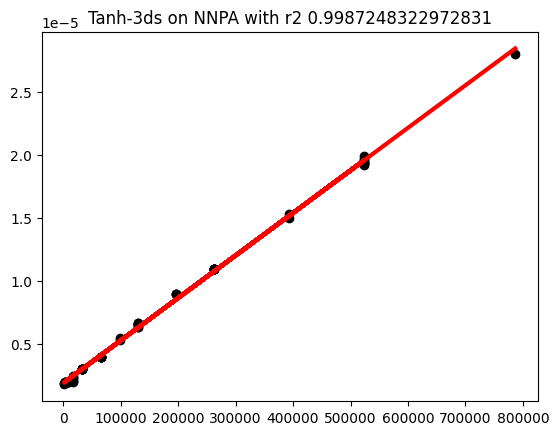

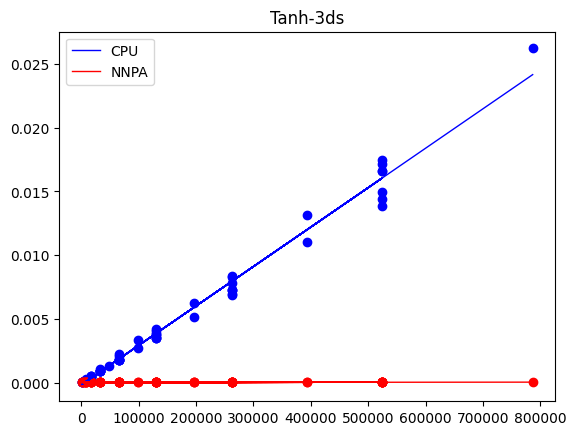

// Operation Tanh_3ds: estimated times.
static double z17_estimatedTimeForCPU_Tanh_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9877462972947725
  return -0.00018632670792973188 + 3.095871999367807e-08 * complexity;
}
// Operation Tanh_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Tanh_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9987248322972831
  return 1.9099330543143847e-06 + 1.6890047978750904e-11 * complexity +1.6890047978750904e-11 * complexity2;
}



In [17]:
regdb["Tanh-3ds"] = compute_reg("Tanh-3ds", dir+"test_tanh_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_log_2025-08-11-16-21-51.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[4.59473252e-09]] , intercept [7.89140071e-07] , r2,  0.9973837821681654


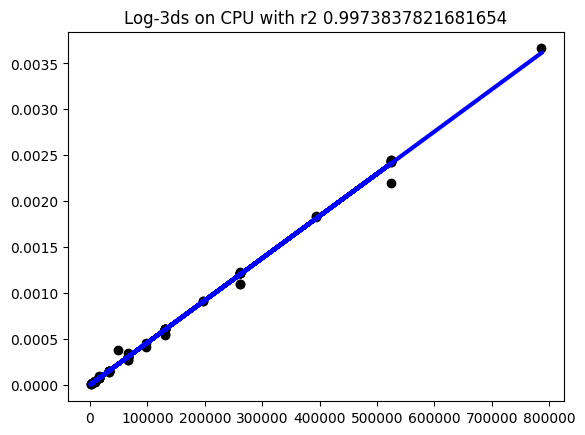

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[3.07255619e-11 3.07255619e-11]] , intercept [1.83371868e-06] , r2,  0.9997954181492037


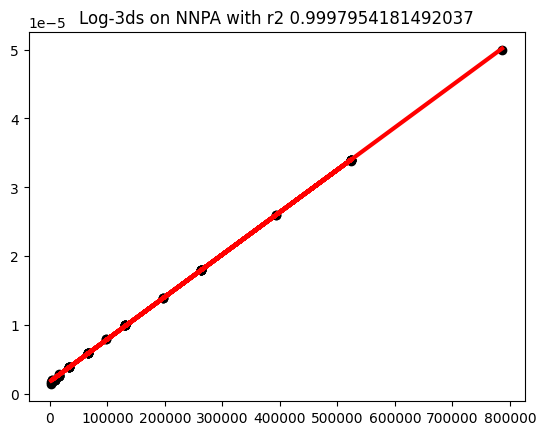

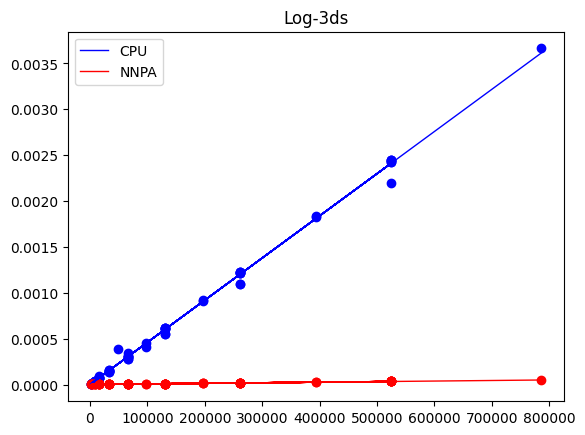

// Operation Log_3ds: estimated times.
static double z17_estimatedTimeForCPU_Log_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9973837821681654
  return 7.891400707816425e-07 + 4.594732517019734e-09 * complexity;
}
// Operation Log_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Log_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9997954181492037
  return 1.833718677223343e-06 + 3.072556188248614e-11 * complexity +3.072556188248613e-11 * complexity2;
}



In [18]:
regdb["Log-3ds"] = compute_reg("Log-3ds", dir+"test_log_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_exp_2025-08-11-16-16-27.csv
CPU : original rows 132 , filtered rows 63
CPU : regression coef,  [[3.6565278e-09]] , intercept [5.00305163e-07] , r2,  0.9966505404381316


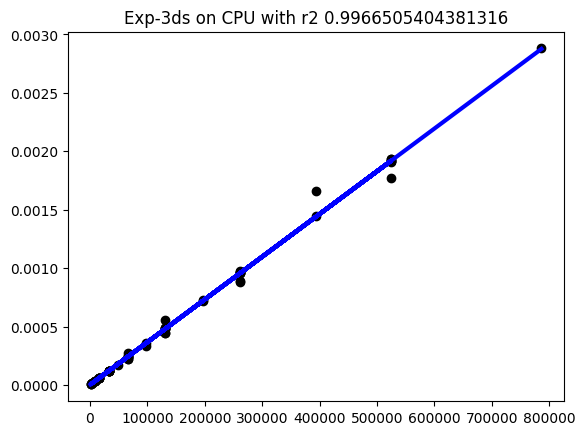

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[2.55816727e-11 2.55816727e-11]] , intercept [2.24589706e-06] , r2,  0.9994918583654459


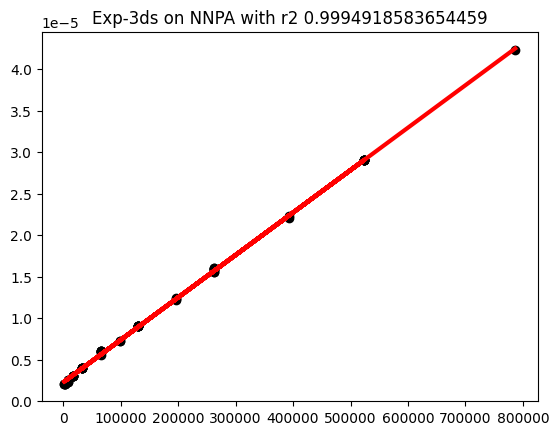

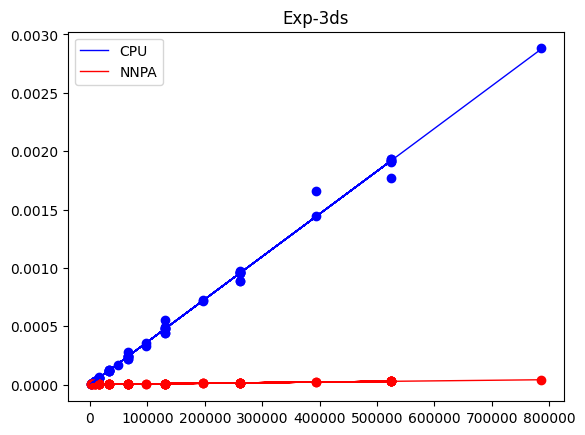

// Operation Exp_3ds: estimated times.
static double z17_estimatedTimeForCPU_Exp_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9966505404381316
  return 5.003051634620576e-07 + 3.656527802065411e-09 * complexity;
}
// Operation Exp_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Exp_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.9994918583654459
  return 2.245897057668368e-06 + 2.55816727002746e-11 * complexity +2.5581672700274598e-11 * complexity2;
}



In [19]:
regdb["Exp-3ds"] = compute_reg("Exp-3ds", dir+"test_exp_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_softmax_2025-08-11-16-09-08.csv
CPU : original rows 132 , filtered rows 45
CPU : regression coef,  [[5.78463189e-09]] , intercept [4.67498311e-06] , r2,  0.9993359067568314


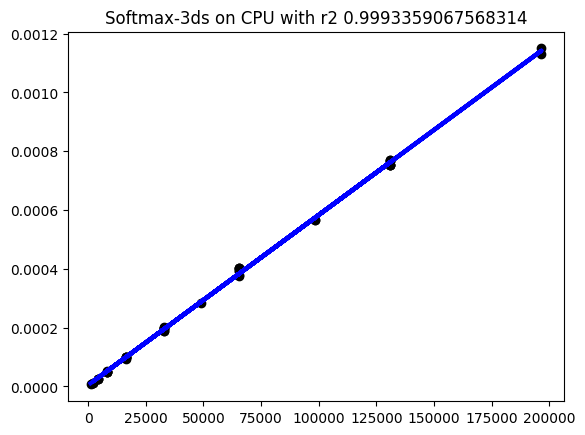

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[9.53201778e-10 9.53201778e-10]] , intercept [-2.10846859e-06] , r2,  0.7701397404077882


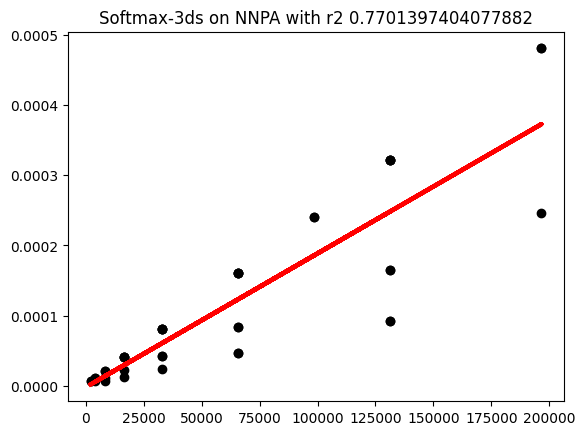

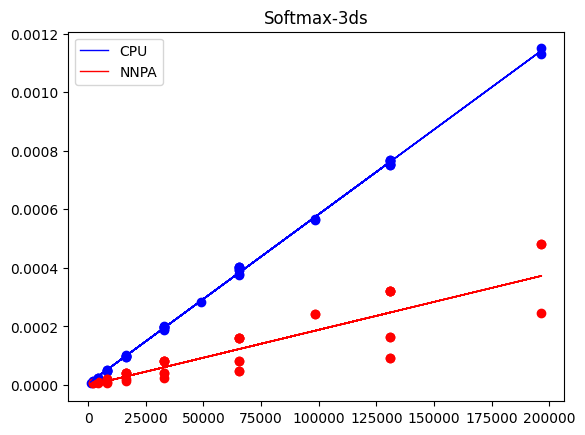

// Operation Softmax_3ds: estimated times.
static double z17_estimatedTimeForCPU_Softmax_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9993359067568314
  return 4.674983112804845e-06 + 5.784631885563881e-09 * complexity;
}
// Operation Softmax_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Softmax_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.7701397404077882
  return -2.1084685896320904e-06 + 9.532017780882657e-10 * complexity +9.532017780882657e-10 * complexity2;
}



In [20]:
regdb["Softmax-3ds"] = compute_reg("Softmax-3ds", dir+"test_softmax_", max_compute=2e5, print_graph=2)

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_reducemean_2025-08-11-16-45-19.csv
CPU : original rows 132 , filtered rows 56
CPU : regression coef,  [[1.27639347e-10]] , intercept [-7.95790625e-08] , r2,  0.9596961036596723


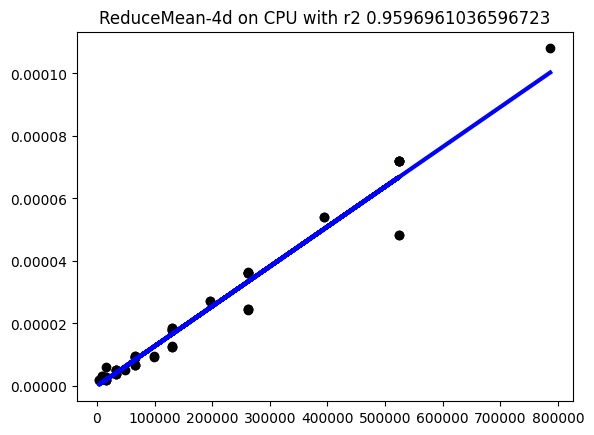

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[9.73201234e-12 9.73201234e-12]] , intercept [1.11027842e-05] , r2,  0.23999718391624125


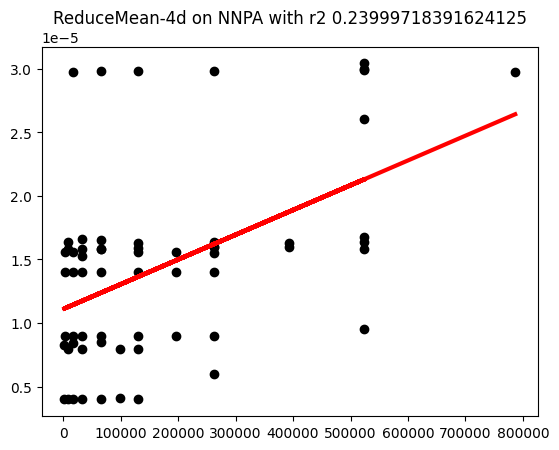

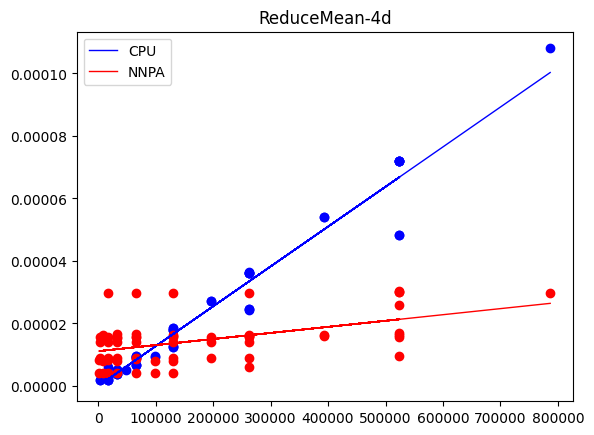

// Operation ReduceMean_4d: estimated times.
static double z17_estimatedTimeForCPU_ReduceMean_4d_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9596961036596723
  return -7.957906245983779e-08 + 1.2763934669440368e-10 * complexity;
}
// Operation ReduceMean_4d: estimated times.
static double z17_estimatedTimeForNNPA_ReduceMean_4d(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.23999718391624125
  return 1.1102784168911405e-05 + 9.732012341718615e-12 * complexity +9.732012341718615e-12 * complexity2;
}



In [21]:
regdb["ReduceMean-4d"] = compute_reg("ReduceMean-4d", dir+"test_reducemean_")

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_stick_2025-08-11-17-11-49.csv
CPU : original rows 132 , filtered rows 35
CPU : regression coef,  [[8.2472063e-11]] , intercept [7.22426724e-07] , r2,  0.9774539162738838


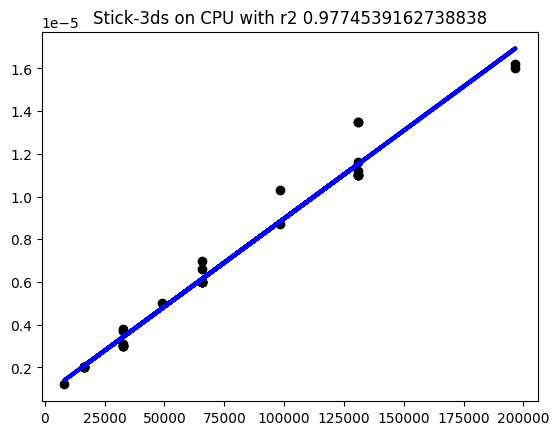

NNPA : original rows 132 , filtered rows 43
NNPA : regression coef,  [[1.58257297e-10 1.58257297e-10]] , intercept [1.35059432e-06] , r2,  0.7157912125873063


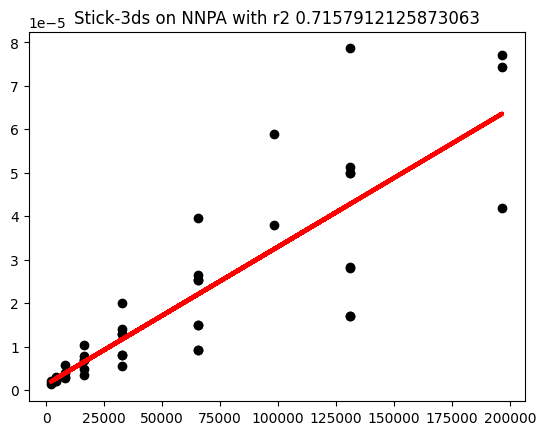

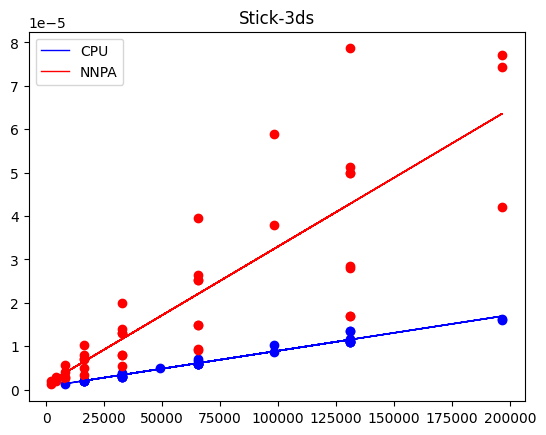

// Operation Stick_3ds: estimated times.
static double z17_estimatedTimeForCPU_Stick_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9774539162738838
  return 7.224267239631871e-07 + 8.247206303588807e-11 * complexity;
}
// Operation Stick_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Stick_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.7157912125873063
  return 1.3505943242343837e-06 + 1.5825729718381625e-10 * complexity +1.5825729718381625e-10 * complexity2;
}



In [22]:
regdb["Stick-3ds"] = compute_reg("Stick-3ds", dir+"test_stick_", max_compute=2e5)

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_stick_2025-08-11-17-11-49.csv
CPU : original rows 132 , filtered rows 53
CPU : regression coef,  [[8.26341914e-11]] , intercept [7.62910743e-07] , r2,  0.9939613340621439


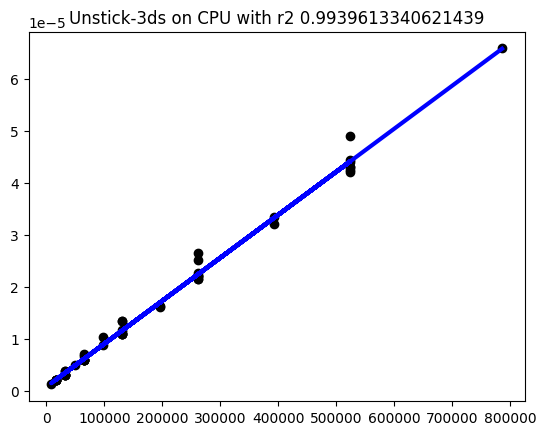

NNPA : original rows 132 , filtered rows 62
NNPA : regression coef,  [[1.25167628e-10 1.25167628e-10]] , intercept [6.72474422e-06] , r2,  0.6018020292783187


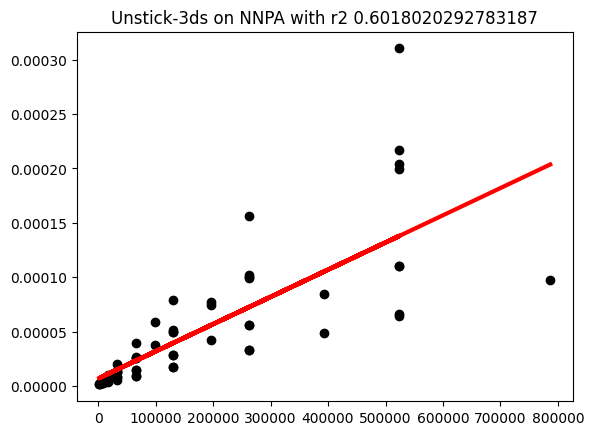

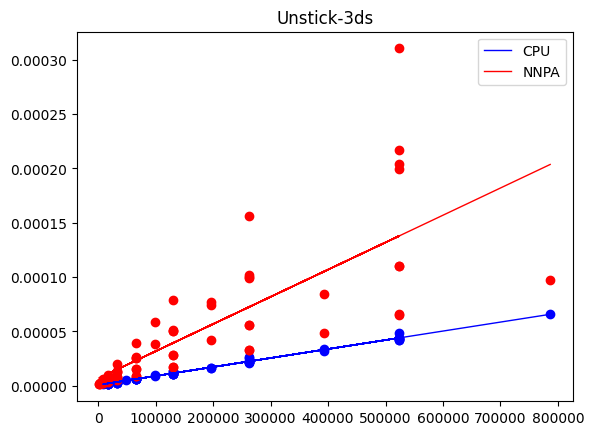

// Operation Unstick_3ds: estimated times.
static double z17_estimatedTimeForCPU_Unstick_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9939613340621439
  return 7.629107434325167e-07 + 8.263419143922785e-11 * complexity;
}
// Operation Unstick_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Unstick_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
  // Regression for NNPA with r2 = 0.6018020292783187
  return 6.724744216429102e-06 + 1.2516762775410042e-10 * complexity +1.251676277541004e-10 * complexity2;
}



In [23]:
regdb["Unstick-3ds"] = compute_reg("Unstick-3ds", dir+"test_stick_")
#plot_regressions(regdb, (("Stick-3ds","nnpa"),("Unstick-3ds","nnpa")))


used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_matmul_3d_2025-08-11-17-09-20.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[4.9506494e-11]] , intercept [3.481228e-07] , r2,  0.9989253937000345


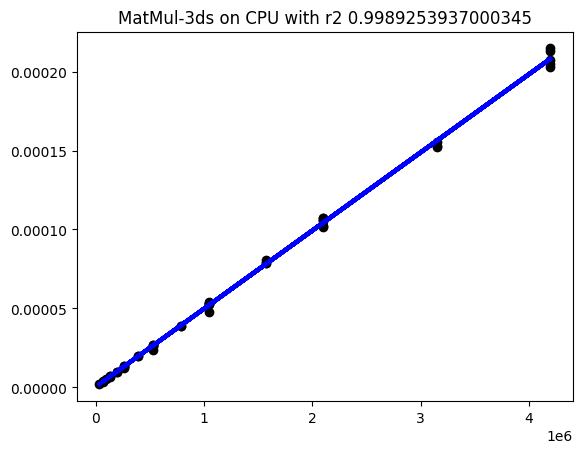

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[8.60238144e-13 8.60238144e-13]] , intercept [2.04142478e-06] , r2,  0.7065204307110055


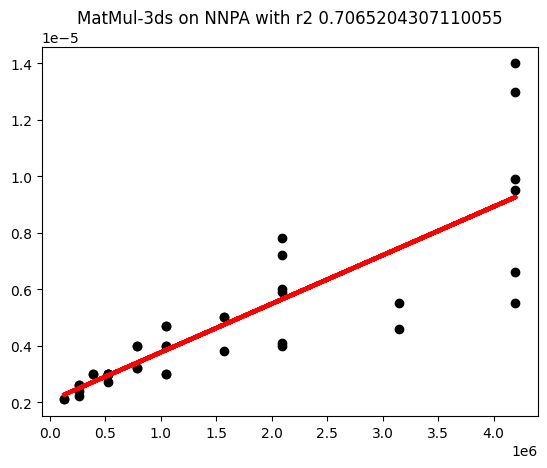

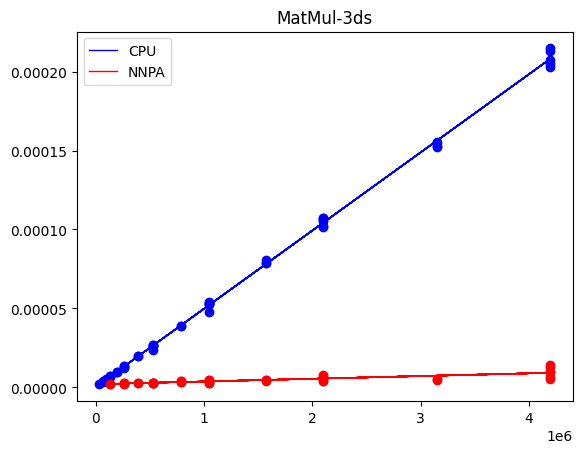

// Operation MatMul_3ds: estimated times.
static double z17_estimatedTimeForCPU_MatMul_3ds_(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.9989253937000345
  return 3.4812280028722275e-07 + 4.950649398979014e-11 * complexity;
}
// Operation MatMul_3ds: estimated times.
static double z17_estimatedTimeForNNPA_MatMul_3ds(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.7065204307110055
  return 2.0414247830279655e-06 + 8.602381442298999e-13 * complexity +8.602381442298999e-13 * complexity2;
}



In [24]:
regdb["MatMul-3ds"] = compute_reg("MatMul-3ds", dir+"test_matmul_3d_", max_compute=5e6, min_e2=32, min_e1=32)

used name as prefix to load this input file /Users/alexe/OM/atmp/res/test_matmul_bcast23_2025-08-11-17-10-35.csv
CPU: Use MatMul 3D compute complexity.
CPU : original rows 90 , filtered rows 45
CPU : regression coef,  [[5.13833001e-11]] , intercept [4.07356685e-07] , r2,  0.9948965187652145


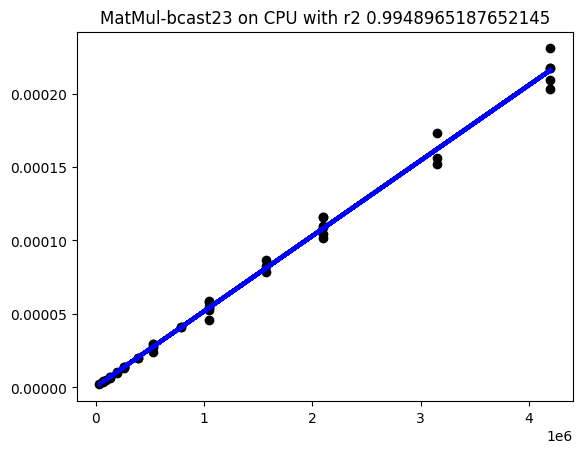

NNPA: Use MatMul 3D compute complexity.
NNPA : original rows 90 , filtered rows 40
NNPA : regression coef,  [[5.59513456e-13 5.59513456e-13]] , intercept [2.18242285e-06] , r2,  0.8436170298814808


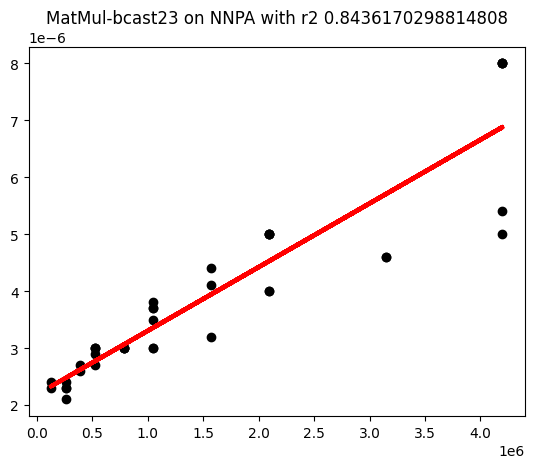

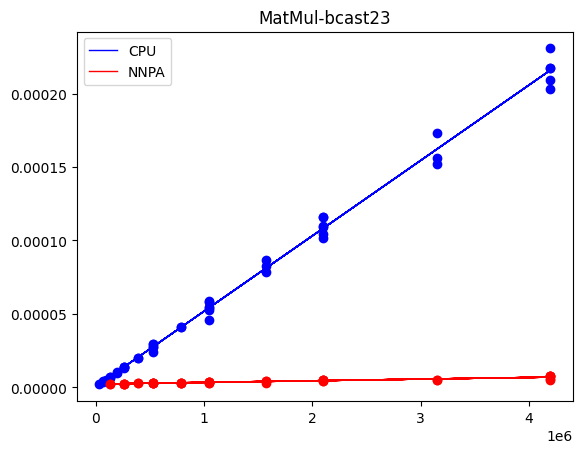

// Operation MatMul_bcast23: estimated times.
static double z17_estimatedTimeForCPU_MatMul_bcast23_(double B, double N, double M, double K) {
  double complexity = B * (N * M * K);
  // Regression for CPU with r2 = 0.9948965187652145
  return 4.0735668466465797e-07 + 5.138330008036225e-11 * complexity;
}
// Operation MatMul_bcast23: estimated times.
static double z17_estimatedTimeForNNPA_MatMul_bcast23(double B, double N, double M, double K) {
  double complexity  = B * ms_ceiling(N, 2.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  double complexity2 = B * ms_ceiling(N, 32.0) * ms_ceiling(M, 64.0) * ms_ceiling(K, 64.0);
  // Regression for NNPA with r2 = 0.8436170298814808
  return 2.182422854387657e-06 + 5.595134562213716e-13 * complexity +5.595134562213716e-13 * complexity2;
}



In [25]:
regdb["MatMul-bcast23"] = compute_reg("MatMul-bcast23", dir+"test_matmul_bcast23_", max_compute=5e6, min_e2=32, min_e1=32)

In [26]:
print("""
/*
 * SPDX-License-Identifier: Apache-2.0
 */

//===----------------- Auto-Generated, do not change  ---------------------===//
//
// Copyright 2025 The IBM Research Authors.
// Generated by the utils/NNPAOpPerfModel/generateModel.ipynb
// See Readme in that directory for more info.
//
// =============================================================================

inline static double ms_ceiling(double n, double m) { return ceil(n / m) * m; }

""")
      
for op in sorted(regdb):
    print(regdb[op]["code"])


/*
 * SPDX-License-Identifier: Apache-2.0
 */

//===----------------- Auto-Generated, do not change  ---------------------===//
//
// Copyright 2025 The IBM Research Authors.
// Generated by the utils/NNPAOpPerfModel/generateModel.ipynb
// See Readme in that directory for more info.
//
// =============================================================================

inline static double ms_ceiling(double n, double m) { return ceil(n / m) * m; }


// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForCPU_Add_3ds_(double e3, double e2, double e1) {
  double complexity = e3 * e2 * e1;
  // Regression for CPU with r2 = 0.9535871953084981
  return 1.068720751279869e-07 + 1.1123201461356356e-10 * complexity;
}
// Operation Add_3ds: estimated times.
static double z17_estimatedTimeForNNPA_Add_3ds(double e3, double e2, double e1) {
  double complexity  = e3 * ms_ceiling(e2, 2.0) * ms_ceiling(e1, 64.0);
  double complexity2 = e3 * ms_ceiling(e2, 32.0) * ms_ceiling(e1, 64.0);
